In [45]:
from statistics import mean
import pandas as pd
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, StratifiedKFold
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from scipy import interp
import warnings
warnings.filterwarnings('ignore')


data = pd.read_csv('features_30_sec.csv')
n_classes=10

X =  data.drop(["label","filename"],axis = 1)
y = data["label"]
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, random_state = 56)
y_train_roc = label_binarize(y_train, classes=list(y.drop_duplicates().values))
cv = StratifiedKFold(n_splits=10, shuffle = True, random_state = 76)

clf_logreg = LogisticRegression()
clf_logreg.fit(X_train, y_train)
y_pred_class_logreg = cross_val_predict(clf_logreg, X_train, y_train, cv = cv)
y_pred_prob_logreg = cross_val_predict(clf_logreg, X_train, y_train, cv = cv, method="predict_proba")

clf_SGD = SGDClassifier()
clf_SGD.fit(X_train, y_train)
y_pred_class_SGD = cross_val_predict(clf_SGD, X_train, y_train, cv = cv)
y_pred_prob_SGD = cross_val_predict(clf_SGD, X_train, y_train, cv = cv, method="decision_function")


clf_rfc = RandomForestClassifier()
clf_rfc.fit(X_train, y_train)
y_pred_class_rfc = cross_val_predict(clf_rfc, X_train, y_train, cv = cv)
y_pred_prob_rfc = cross_val_predict(clf_rfc, X_train, y_train, cv = cv, method="predict_proba")

clf_knn = KNeighborsClassifier()
clf_knn.fit(X_train, y_train)
y_pred_class_knn = cross_val_predict(clf_knn, X_train, y_train, cv = cv)
y_pred_prob_knn = cross_val_predict(clf_knn, X_train, y_train, cv = cv, method="predict_proba")

In [46]:
from sklearn.base import BaseEstimator
import numpy as np

class BaseClassifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)
    
base_clf = BaseClassifier()
cross_val_score(base_clf, X_train, y_train, cv=10, scoring="accuracy").mean()




0.0

In [47]:
acc_logreg = cross_val_score(clf_logreg, X_train, y_train, cv = cv, scoring = 'accuracy').mean()
acc_SGD = cross_val_score(clf_SGD, X_train, y_train, cv = cv, scoring = 'accuracy').mean()
acc_rfc = cross_val_score(clf_rfc, X_train, y_train, cv = cv, scoring = 'accuracy').mean()
acc_knn = cross_val_score(clf_knn, X_train, y_train, cv = cv, scoring = 'accuracy').mean()
acc_logreg, acc_SGD, acc_rfc,acc_knn


(0.3106666666666667, 0.2013333333333333, 0.768, 0.2653333333333333)

In [48]:

logloss_logreg = cross_val_score(clf_logreg, X_train, y_train, cv = cv, scoring = 'neg_log_loss').mean()
logloss_rfc = cross_val_score(clf_rfc, X_train, y_train, cv = cv, scoring = 'neg_log_loss').mean()
logloss_knn = cross_val_score(clf_knn, X_train, y_train, cv = cv, scoring = 'neg_log_loss').mean()
from sklearn.calibration import CalibratedClassifierCV

new_clf_SGD = CalibratedClassifierCV(clf_SGD)
new_clf_SGD.fit(X_train, y_train)
logloss_SGD = cross_val_score(new_clf_SGD, X_train, y_train, cv = cv, scoring = 'neg_log_loss').mean()

logloss_logreg, logloss_SGD, logloss_rfc,logloss_knn


(-1.939727459518879,
 -2.3030686521768624,
 -0.9288226222203347,
 -13.885557752475489)

In [49]:
def fpr_tpr_roc_auc(y_binarized, y_pred_prob):
    fpr = dict()
    tpr = dict()
    threshold = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], threshold[i] = roc_curve(y_binarized[:, i], y_pred_prob[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    fpr["micro"], tpr["micro"], _ = roc_curve(y_binarized.ravel(), y_pred_prob.ravel())
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= n_classes
    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
    return fpr, tpr, threshold, roc_auc
def roc_plot(fpr, tpr,roc_auc):


    plt.figure(figsize=(20,10))
    plt.plot(
        fpr["micro"],
        tpr["micro"],
        label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
        color="deeppink",
        linestyle=":",
        linewidth=4,
    )
    plt.plot(
        fpr["macro"],
        tpr["macro"],
        label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
        color="navy",
        linestyle=":",
        linewidth=4,
    )
    colors = cycle(["aqua", "darkorange", "cornflowerblue"])
    for i, color in zip(range(n_classes), colors):
        plt.plot(
            fpr[i],
            tpr[i],
            color=color,
            label="ROC curve of class {0} (area = {1:0.2f})".format(i, roc_auc[i]),
        )

    plt.plot([0, 1], [0, 1], "k--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Some extension of Receiver operating characteristic to multiclass")
    plt.legend(loc="lower right")
    plt.show()



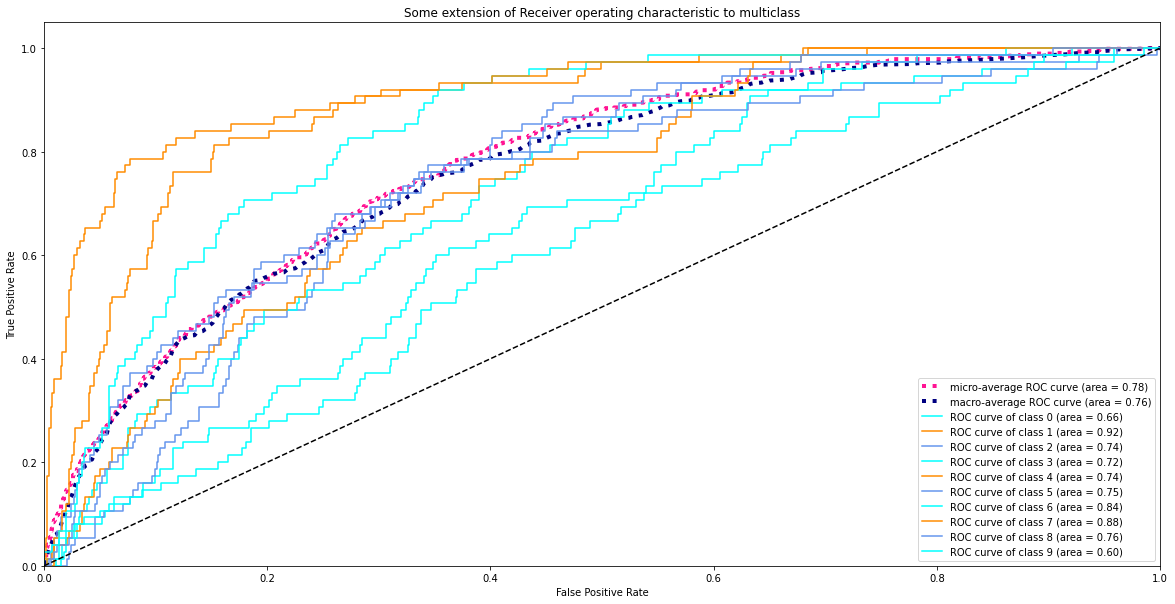

In [50]:
fpr_logreg, tpr_logreg, threshold_logreg, roc_auc_logreg=fpr_tpr_roc_auc(y_train_roc,y_pred_prob_logreg)

roc_plot(fpr_logreg, tpr_logreg, roc_auc_logreg)

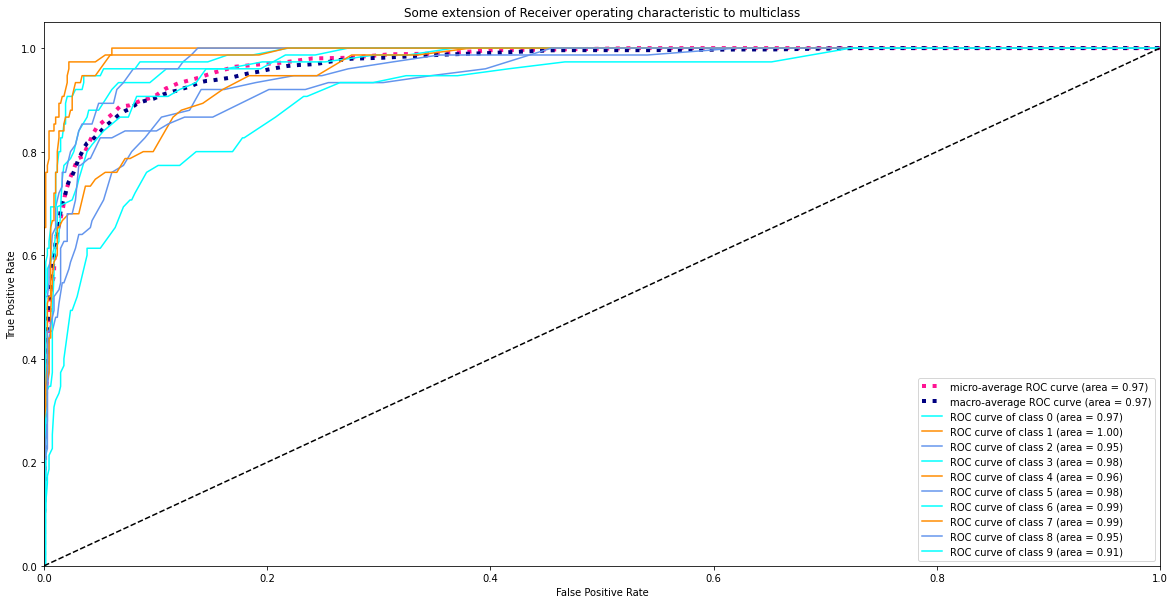

In [51]:
fpr_rfc, tpr_rfc, threshold_rfc,roc_auc_rfc=fpr_tpr_roc_auc(y_train_roc,y_pred_prob_rfc)

roc_plot(fpr_rfc, tpr_rfc, roc_auc_rfc)

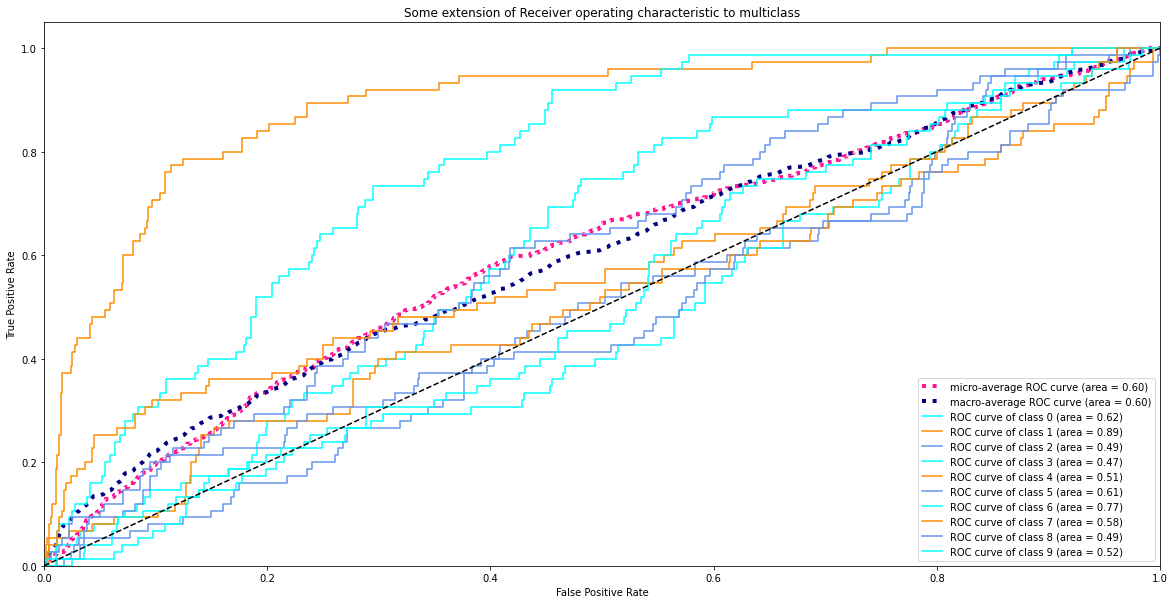

In [52]:
fpr_sgd, tpr_sgd, threshold_sgd,roc_auc_sgd=fpr_tpr_roc_auc(y_train_roc,y_pred_prob_SGD)

roc_plot(fpr_sgd, tpr_sgd, roc_auc_sgd)

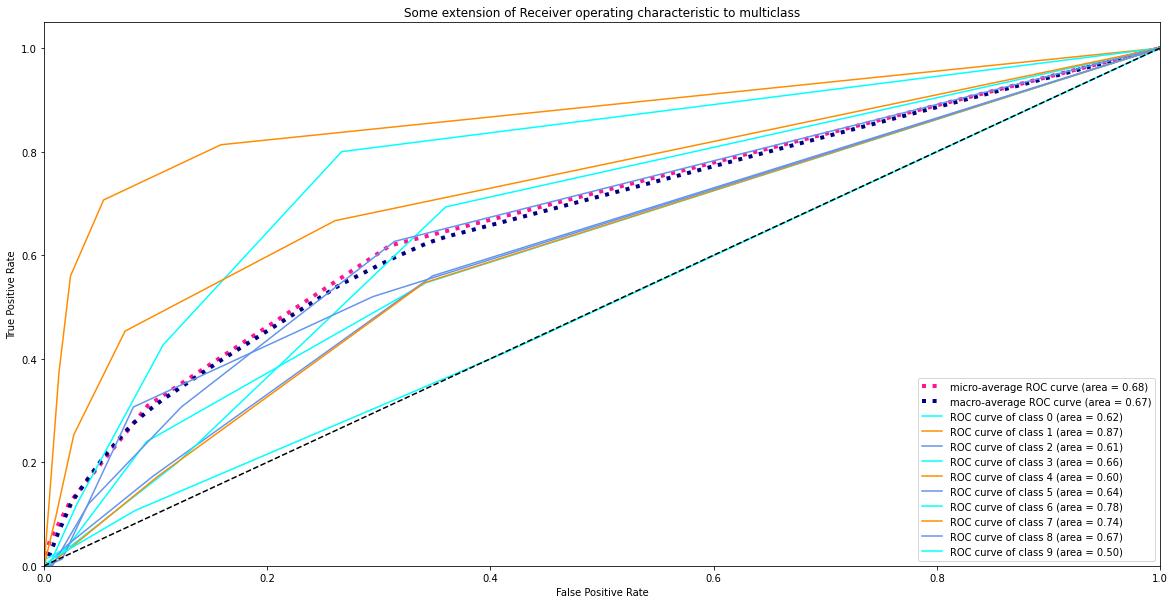

In [53]:
fpr_knn, tpr_knn, threshold_knn,roc_auc_knn=fpr_tpr_roc_auc(y_train_roc,y_pred_prob_knn)

roc_plot(fpr_knn, tpr_knn, roc_auc_knn)


In [54]:
# define a function that accepts a threshold and prints sensitivity and specificity
def evaluate_threshold(tpr, fpr,clf_threshold, threshold):
    return tpr[clf_threshold > threshold][-1], 1 - fpr[clf_threshold > threshold][-1]

In [55]:
evaluate_threshold(tpr_sgd[0], fpr_sgd[0], threshold_sgd[0], 0.2), evaluate_threshold(fpr_rfc[0], fpr_rfc[0], fpr_rfc[0], 0.8)

((0.08, 0.9555555555555556), (1.0, 0.0))

In [56]:
roc_auc_mean_logreg=[roc_auc_logreg[i] for i in range(10)]
roc_auc_mean_sgd=[roc_auc_sgd[i] for i in range(10)]
roc_auc_mean_rfc=[roc_auc_rfc[i] for i in range(10)]
roc_auc_mean_knn=[roc_auc_knn[i] for i in range(10)]
mean(roc_auc_mean_logreg),mean(roc_auc_mean_sgd),mean(roc_auc_mean_rfc),mean(roc_auc_mean_knn)



(0.7620641975308642,
 0.5951367901234568,
 0.9674587654320987,
 0.6688395061728395)

In [57]:
report_logreg = metrics.classification_report(y_train, y_pred_class_logreg)   
report_SGD = metrics.classification_report(y_train, y_pred_class_SGD)
report_rfc = metrics.classification_report(y_train, y_pred_class_rfc)
report_knn = metrics.classification_report(y_train, y_pred_class_knn)
print("report_logreg " +  "\n" + report_logreg,"report_SGD "  +  "\n" +  report_SGD,"report_rfc "  +  "\n" +  report_rfc,"report_knn "  +  "\n" +  report_knn, sep = "\n")


report_logreg 
              precision    recall  f1-score   support

       blues       0.09      0.05      0.07        75
   classical       0.46      0.79      0.58        75
     country       0.20      0.19      0.19        75
       disco       0.30      0.25      0.27        75
      hiphop       0.21      0.07      0.10        75
        jazz       0.22      0.23      0.23        75
       metal       0.32      0.55      0.40        75
         pop       0.45      0.56      0.50        75
      reggae       0.33      0.33      0.33        75
        rock       0.16      0.09      0.12        75

    accuracy                           0.31       750
   macro avg       0.27      0.31      0.28       750
weighted avg       0.27      0.31      0.28       750

report_SGD 
              precision    recall  f1-score   support

       blues       0.13      0.09      0.11        75
   classical       0.46      0.41      0.43        75
     country       0.10      0.05      0.07        